# Mineração de Dados
---

In [2]:
# Importações
import os
import networkx as nx

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Trabalho 3 - Regras de associação
---
- Tema: Regras de Associação
- Alunos: Gabriel Faria e Vinicius Oliveira
- Recomendação de artistas e estratégias de marketing focadas

## Intuito do trabalho:
---
### Elaborar e analisar regras de associação para artistas musicais de interesse, tratando das seguintes etapas:
- Transformar os dados de forma apropriada para serem tratados
- Realizar análises de regras de associação considerando todo o conjunto e também fazendo filtros por sexo e país
- Entregar um relatório, como no último trabalho
- Apresentar os resultados alcançados

## Leitura dos dados
---

In [3]:
# Leitura de todos os dados -> comentado, pois precisamos utilizar os dados do grupo
# Read with dask datafram and compute dask disk df to pandas df
#df = dd.read_csv('dataset/trabalho3_dados_*.csv').compute()
#df

In [4]:
df = pd.read_csv('data/trabalho3_dados_4.csv')
df

,idUsuario,artista,sexo,pais
0,5,dream theater,m,Finland
1,5,ac/dc,m,Finland
2,5,metallica,m,Finland
3,5,iron maiden,m,Finland
4,5,bob marley & the wailers,m,Finland
...,...,...,...,...
58450,19714,led zeppelin,m,United Kingdom
58451,19714,slipknot,m,United Kingdom
58452,19714,children of bodom,m,United Kingdom
58453,19714,vader,m,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58455 entries, 0 to 58454
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   idUsuario  58455 non-null  int64 
 1   artista    58455 non-null  object
 2   sexo       58455 non-null  object
 3   pais       58455 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


## Análise inicial e entendimento da base que iremos trabalhar
---
- Análises gerais de entendimento da base
- 72,8% são do sexo masculino
- Talvez se os gêneros fossem diferentes teríamos uma distribuição com maior quantidade de mulheres?
- Dos 10 países com mais usuários, EUA representa quase 30%

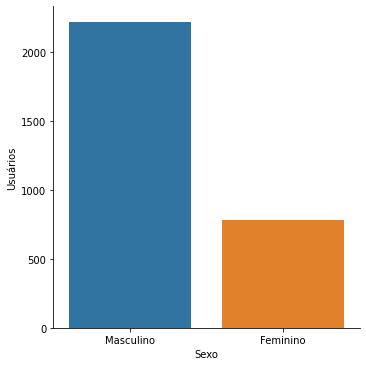

In [6]:
# Usuários
g = sns.catplot(data=df.groupby("idUsuario").first(), x="sexo", kind="count")
g.set_ylabels("Usuários")
g.set_xlabels("Sexo")
g.set_xticklabels(["Masculino", "Feminino"])

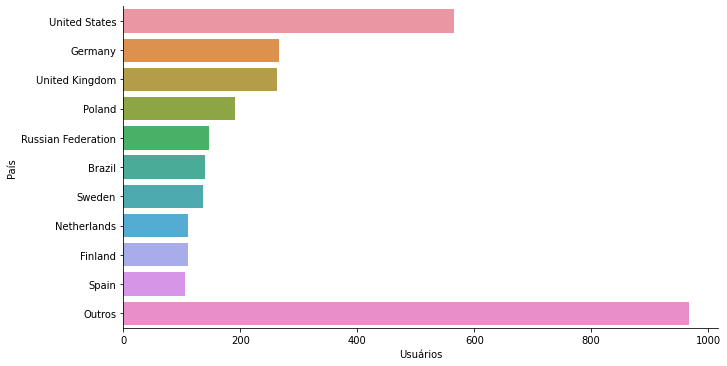

In [7]:
# Usuários
df_gp = df.groupby("idUsuario").first()

freq = list(df_gp["pais"].value_counts().index[:10])

df_in = df_gp[df_gp["pais"].isin(freq)]
df_out = df_gp[~df_gp["pais"].isin(freq)].copy()
df_out["pais"] = "Outros"

g = sns.catplot(
    data=pd.concat([df_in, df_out]),
    y="pais",
    kind="count",
    aspect=2,
    order=freq + ["Outros"],
    orient="h"
)
g.set_ylabels("País")
g.set_xlabels("Usuários")

Text(0.5, 1.0, 'Os 30 maiores artistas mais escutados')

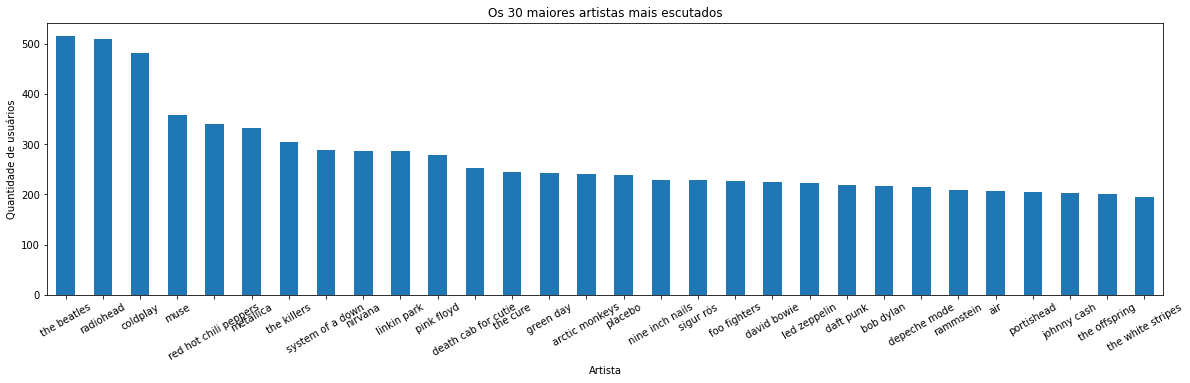

In [8]:
# Usuários
df.groupby("artista")['idUsuario'].count().reset_index().rename(columns={'idUsuario': 'qtdUsuarios'}).sort_values('qtdUsuarios', ascending=False)[:30].plot('artista', 'qtdUsuarios', kind='bar', figsize=(20, 5), rot=30, legend=None)
plt.ylabel('Quantidade de usuários')
plt.xlabel("Artista")
plt.title('Os 30 maiores artistas mais escutados')

In [9]:
pie_countries = df.pais.value_counts().index[0:10]
df.pais.value_counts()

United States           11574
United Kingdom           5970
Germany                  5331
Poland                   3360
Sweden                   2863
                        ...  
Thailand                    7
Bolivia                     6
Bhutan                      4
Puerto Rico                 3
United Arab Emirates        1
Name: pais, Length: 93, dtype: int64

Text(0.5, 1.0, 'Os 10 países com mais usuários')

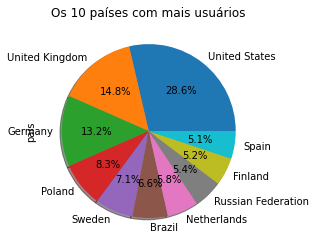

In [10]:
df[df.pais.isin(pie_countries)].pais.value_counts().plot(kind='pie', shadow=True, autopct='%1.1f%%')
plt.title('Os 10 países com mais usuários')

In [11]:
df.sexo.value_counts()

m    41955
f    16500
Name: sexo, dtype: int64

Text(0.5, 1.0, 'Distribuição de gênero')

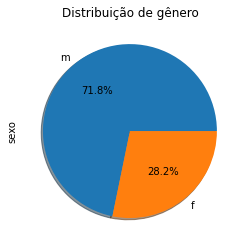

In [12]:
df.sexo.value_counts().plot(kind='pie', shadow=True, autopct='%1.1f%%')
plt.title('Distribuição de gênero')

In [13]:
df.artista.value_counts()

the beatles                           516
radiohead                             509
coldplay                              482
muse                                  358
red hot chili peppers                 341
                                     ... 
captain beefheart & his magic band     16
paul mccartney                         15
girls aloud                            15
poets of the fall                      14
janet jackson                           9
Name: artista, Length: 1004, dtype: int64

In [14]:
df.idUsuario.value_counts()

5765     52
6380     49
16828    48
5756     47
6678     47
         ..
10173     1
16695     1
14810     1
9659      1
16362     1
Name: idUsuario, Length: 3000, dtype: int64

# Transformando a base para ser utilizada nas análises
- Entender se as ocorrências a frequência com que um itemset de mesmos artistas acontecem
- Co-ocorrências de um conjunto de artistas para vários usuários
- Extrair itemsets frequentes, para extrair regras de associação dos conjuntos

### Tratamento e Pré Processamento
---
- Conversão para variáveis dummies, com variáveis indicadoras
- Cada coluna possui indicação de um artista
- Cada linha é uma usuário, a coluna indica se o usuário possui o artista na lista

In [15]:
# Utilizamos essa biblioteca também para alguns testes
# df_dummies = pd.get_dummies(df.artista, prefix_sep='')
#df = pd.concat([df, df_dummies], axis=1)

In [16]:
transactions = df.groupby("idUsuario")["artista"].aggregate(list)

encoder = TransactionEncoder()
df_t = pd.DataFrame(encoder.fit_transform(transactions), columns=encoder.columns_)
df_t

,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,[unknown],...,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7,Édith piaf
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2997,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
df = pd.concat([df, df_t], axis=1)

In [18]:
df.columns

Index(['idUsuario', 'artista', 'sexo', 'pais',
       '...and you will know us by the trail of dead', '2pac', '3 doors down',
       '30 seconds to mars', '311', '36 crazyfists',
       ...
       'wilco', 'within temptation', 'wolfgang amadeus mozart', 'wu-tang clan',
       'yann tiersen', 'yeah yeah yeahs', 'yellowcard', 'yo la tengo',
       'zero 7', 'Édith piaf'],
      dtype='object', length=1008)

In [19]:
# Testando
df['yellowcard'].sum()

21

In [20]:
df['[unknown]'].sum()

85

- Remover a coluna de artista desconhecido, 
- pois não faz sentido ter essa informação para recomendação de artista
- já que não é um artista específico

In [21]:
df = df.drop(columns=['[unknown]'])

- Acesso ao conjunto dos dados originais

In [22]:
df.iloc[:,:4]

,idUsuario,artista,sexo,pais
0,5,dream theater,m,Finland
1,5,ac/dc,m,Finland
2,5,metallica,m,Finland
3,5,iron maiden,m,Finland
4,5,bob marley & the wailers,m,Finland
...,...,...,...,...
58450,19714,led zeppelin,m,United Kingdom
58451,19714,slipknot,m,United Kingdom
58452,19714,children of bodom,m,United Kingdom
58453,19714,vader,m,United Kingdom


- Acesso ao conjunto dos dados da análise de regras de associação
- Nesse caso é a matriz de 0 e 1, ou podendo ser também False e True

In [23]:
# dataset binário
df.iloc[:,4:]

,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,a day to remember,...,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7,Édith piaf
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Análises dos dados para construção das regras de associação
---
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

Suporte é a quantidade de transações que contêm elementos no itemset

Abaixo temos o suporte e o suporte relativo

Cardinalidade dos elementos associados aos artistas para cada usuário

Ter um suporte mínimo, que é o limiar de suporte mínimo, para gerar os itemsets frequentes, para depois gerar as regras

#### Info
- dataset transacional
- min_suport é o suporte relativo
- real_support é a quantidade de vezes que o itemset aparece
- o support na biblioteca nada mais é que o suporte relativo

In [24]:

frequent_itemsets = apriori(df_t, min_support=0.01, use_colnames=True) # 0,4% limiar de suporte mínimo
#frequent_itemsets['real_support'] = frequent_itemsets['support']*df.shape[0]
#frequent_itemsets['elements_length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets


,support,itemsets
0,0.011667,(...and you will know us by the trail of dead)
1,0.025333,(2pac)
2,0.031333,(3 doors down)
3,0.033333,(30 seconds to mars)
4,0.011333,(311)
...,...,...
1811,0.010333,"(the beatles, sigur rós, radiohead)"
1812,0.012000,"(the cure, the beatles, radiohead)"
1813,0.011333,"(the beatles, the smashing pumpkins, radiohead)"
1814,0.010667,"(the beatles, radiohead, the white stripes)"


- Gerar regras que atendem a um critério/limiar de confiança mínima
- Gerando as regras de associação a partir dos itemsets definidos acima
- Usar a confiança como limiar de restrição

In [27]:
regras = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

regras.sort_values(by="lift", ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(beyoncé),(rihanna),0.024667,0.045333,0.015333,0.621622,13.712242,0.014215,2.523048
23,(the pussycat dolls),(rihanna),0.017667,0.045333,0.010667,0.603774,13.318535,0.009866,2.409397
70,"(slipknot, system of a down)",(koЯn),0.020667,0.046000,0.012000,0.580645,12.622721,0.011049,2.274923
69,"(koЯn, system of a down)",(slipknot),0.022667,0.048667,0.012000,0.529412,10.878324,0.010897,2.021583
63,"(megadeth, metallica)",(iron maiden),0.017667,0.059333,0.010333,0.584906,9.857961,0.009285,2.266152
...,...,...,...,...,...,...,...,...,...
0,(andrew bird),(radiohead),0.020333,0.169667,0.010333,0.508197,2.995266,0.006883,1.688344
25,(the flaming lips),(the beatles),0.026667,0.172000,0.013667,0.512500,2.979651,0.009080,1.698462
46,"(coldplay, pink floyd)",(the beatles),0.023667,0.172000,0.012000,0.507042,2.947920,0.007929,1.679657
11,(devendra banhart),(radiohead),0.025333,0.169667,0.012667,0.500000,2.946955,0.008368,1.660667


- Lift é uma medida de correlação associada a X e Y (onde X -> Y é a regra de associação)
- Lifts pode ser usado para fazer avaliação de ordem, para buscar regras de interesse a partir dessa métrica
- Leverage e Conviction também são outras métricas possíveis que podemso usar para avaliar as regras de associação
- Podemos até mesmo ordenar de acordo com qual métrica queremos avaliar

### Visualizando os resultados das métricas

referencia: https://intelligentonlinetools.com/blog/2018/02/10/how-to-create-data-visualization-for-association-rules-in-data-mining/

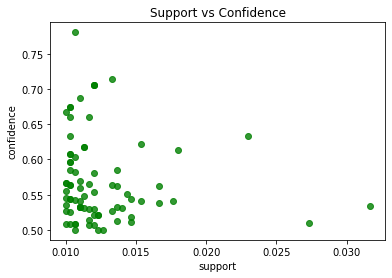

In [28]:
plt.scatter(regras['support'], regras['confidence'], alpha=0.8, c='g')
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

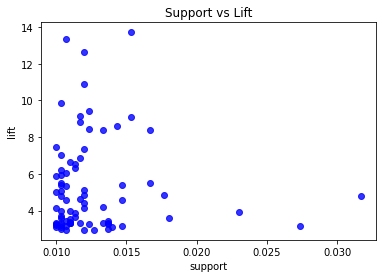

In [29]:
plt.scatter(regras['support'], regras['lift'], alpha=0.8, c='b')
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

- Usamos a bilioteca Numpy para gerar uma possível tendência
- Para isso utilizamos do método dos mínimos quadrados para determinar o ajusta de mínimos quadrados
- Em outros bases, poderíamos ver uma tendência entre as métricas

Text(0.5, 1.0, 'Lift vs Support')

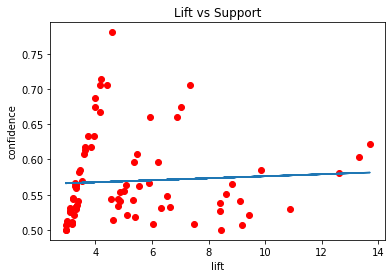

In [51]:
fit = np.polyfit(regras['lift'], regras['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(regras['lift'], regras['confidence'], 'ro', regras['lift'], fit_fn(regras['lift']))

plt.xlabel('lift')
plt.ylabel('confidence')
plt.title('Lift vs Support')

#### Análise gráfica dos resultados por meio de grafos
- Usamos a biblioteca NetworkX para construir um gráfico de rede para verificar a associação entre antecedentes e consequentes obtidos após a regra de associação
- Achamos alguns grupo que se combinam, podendo ser artistas que as pessoas costumam sempre ouvir, dado que ouve outra
- Vemos vários grupos de artistas que podem ser de estilos parecidos, em que gostos musicais se alinham com esses artistas
- A partir disso, podemos recomendar artistas, de acordo com cada agrupamento visto no grafo abaixo

referencia: https://www.kaggle.com/bbhatt001/bakery-business-model-association-rules

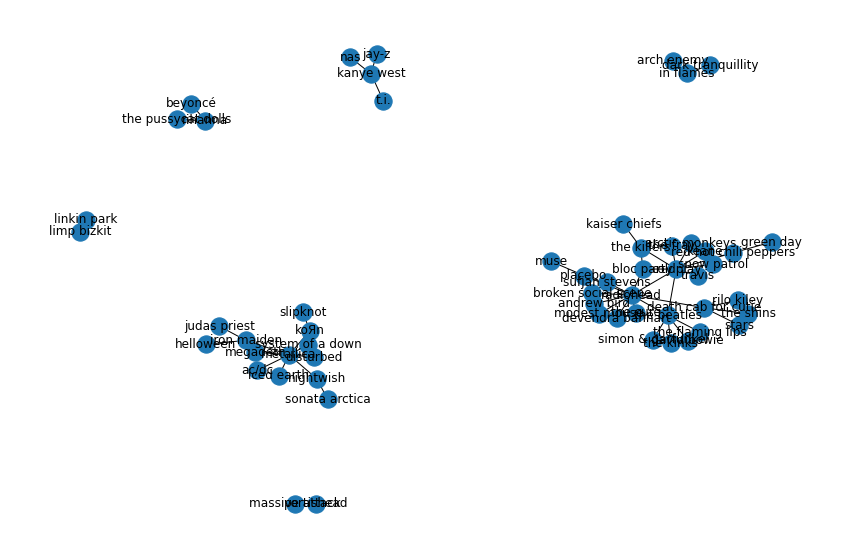

In [85]:
fig, ax=plt.subplots(figsize=(15,10))
GA=nx.from_pandas_edgelist(regras, source='antecedents', target='consequents')
nx.draw(GA, with_labels=True)
plt.show()

- Filtramos após isso, todos os antecedentes e consequentes que possuem Metallica
- Com isso podemos ver fielmente quais bandas geralmente as pessoas escutam a partir de que escutam Metallica
- De acordo com o gosto musical, faz sentido na prática essas bandas estarem juntas
- A partir disso, podemos pensar em um sistema de recomendação que cria rádios de artistas
- Com essa análise, podemos recomendar esses artistas, dado que a pessoa gosta desse gênero de música e frequentemente escuta Metallica

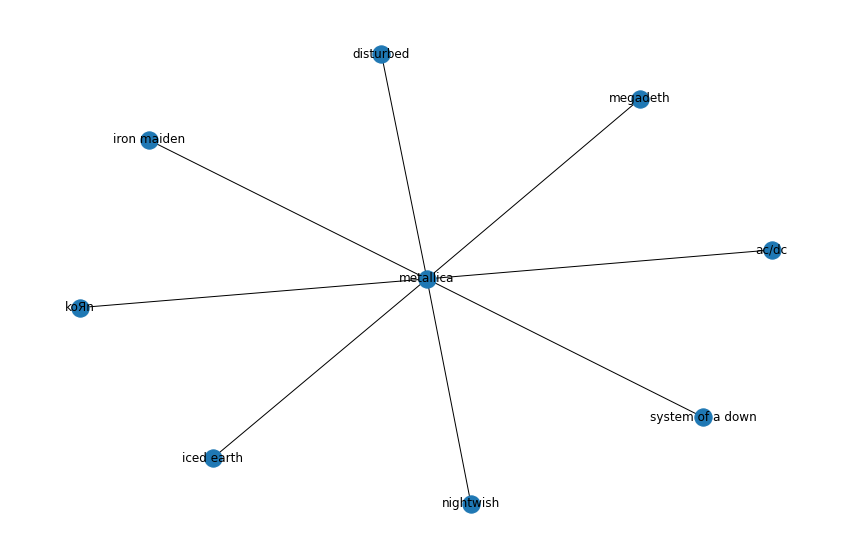

In [84]:
# para retirar do dicionário e não aparecer lixo na impressão do nome do artista
referefeasdddddddfs
regras.antecedents = regras.antecedents.apply(lambda x: next(iter(x)))
regras.consequents = regras.consequents.apply(lambda x: next(iter(x)))

metallica_rules = regras[regras.antecedents.astype(str).str.contains('metallica', case=False) | regras.consequents.astype(str).str.contains('metallica', case=False)]

fig, ax=plt.subplots(figsize=(15,10))
GA=nx.from_pandas_edgelist(metallica_rules, source='antecedents', target='consequents')
nx.draw(GA, with_labels=True)
plt.show()

### Regras de Associação (Geral)

In [52]:
transactions = df.groupby("idUsuario")["artista"].aggregate(list)
transactions

idUsuario
5        [dream theater, ac/dc, metallica, iron maiden,...
9        [arch enemy, strapping young lad, kreator, chi...
14       [sonic youth, the fall, mogwai, the velvet und...
22       [the jam, maxïmo park, supergrass, simon & gar...
24       [the byrds, leonard cohen, the beatles, simon ...
                               ...                        
19688    [bullet for my valentine, escape the fate, 30 ...
19701    [placebo, animal collective, crystal castles, ...
19703    [the offspring, pearl jam, the smashing pumpki...
19708    [coldplay, amy winehouse, armin van buuren, mo...
19714    [misfits, type o negative, arch enemy, red hot...
Name: artista, Length: 3000, dtype: object

In [53]:
encoder = TransactionEncoder()
df_t = pd.DataFrame(encoder.fit_transform(transactions), columns=encoder.columns_)
df_t

,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,[unknown],...,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7,Édith piaf
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2997,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [54]:
min_support = 0.01
file_path = f"data/itemsets_{min_support}.csv"

if not os.path.isfile(file_path):
    itemsets = apriori(df_t, min_support=min_support, use_colnames=True)
    itemsets.to_csv(file_path, index=False)
else:
    itemsets = pd.read_csv(file_path, converters={"itemsets": eval})

itemsets["itemsets"]

0        (...and you will know us by the trail of dead)
1                                                (2pac)
2                                        (3 doors down)
3                                  (30 seconds to mars)
4                                                 (311)
                             ...                       
1811                (the beatles, sigur rós, radiohead)
1812                 (the cure, the beatles, radiohead)
1813    (the beatles, the smashing pumpkins, radiohead)
1814        (the beatles, radiohead, the white stripes)
1815       (the cure, the smashing pumpkins, radiohead)
Name: itemsets, Length: 1816, dtype: object

In [55]:
itemsets["itemsets"].apply(len).describe()

count    1816.000000
mean        1.673458
std         0.558116
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: itemsets, dtype: float64

In [56]:
rules_gen = association_rules(itemsets, metric="confidence", min_threshold=0.0).sort_values(
    by="lift", ascending=False
)
rules_gen

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1200,(nas),(jay-z),0.026000,0.031000,0.012333,0.474359,15.301902,0.011527,1.843463
1201,(jay-z),(nas),0.031000,0.026000,0.012333,0.397849,15.301902,0.011527,1.617536
308,(beyoncé),(rihanna),0.024667,0.045333,0.015333,0.621622,13.712242,0.014215,2.523048
309,(rihanna),(beyoncé),0.045333,0.024667,0.015333,0.338235,13.712242,0.014215,1.473837
1985,(the pussycat dolls),(rihanna),0.017667,0.045333,0.010667,0.603774,13.318535,0.009866,2.409397
...,...,...,...,...,...,...,...,...,...
588,(coldplay),(metallica),0.160667,0.111000,0.014667,0.091286,0.822399,-0.003167,0.978306
1393,(the beatles),(linkin park),0.172000,0.095667,0.013000,0.075581,0.790049,-0.003455,0.978273
1392,(linkin park),(the beatles),0.095667,0.172000,0.013000,0.135889,0.790049,-0.003455,0.958210
1375,(radiohead),(linkin park),0.169667,0.095667,0.012333,0.072692,0.759842,-0.003898,0.975224


## Filtros de sexo, país e gerais para gerar as regras de associação
---

### Regras de Associação (Sexo Masculino)

In [57]:
transactions = df[df["sexo"] == "m"].groupby("idUsuario")["artista"].aggregate(list)
transactions

idUsuario
5        [dream theater, ac/dc, metallica, iron maiden,...
9        [arch enemy, strapping young lad, kreator, chi...
14       [sonic youth, the fall, mogwai, the velvet und...
22       [the jam, maxïmo park, supergrass, simon & gar...
24       [the byrds, leonard cohen, the beatles, simon ...
                               ...                        
19677    [doves, the new pornographers, the weakerthans...
19685    [philip glass, rammstein, pink floyd, moby, bl...
19688    [bullet for my valentine, escape the fate, 30 ...
19708    [coldplay, amy winehouse, armin van buuren, mo...
19714    [misfits, type o negative, arch enemy, red hot...
Name: artista, Length: 2219, dtype: object

In [58]:
encoder = TransactionEncoder()
df_t = pd.DataFrame(encoder.fit_transform(transactions), columns=encoder.columns_)
df_t

,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,[unknown],...,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7,Édith piaf
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2214,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2215,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2216,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2217,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [59]:
min_support = 0.01
file_path = f"data/itemsets_sexo_{min_support}.csv"

if not os.path.isfile(file_path):
    itemsets = apriori(df_t, min_support=min_support, use_colnames=True)
    itemsets.to_csv(file_path, index=False)
else:
    itemsets = pd.read_csv(file_path, converters={"itemsets": eval})

itemsets["itemsets"]

0          (...and you will know us by the trail of dead)
1                                                  (2pac)
2                                          (3 doors down)
3                                    (30 seconds to mars)
4                                                   (311)
                              ...                        
1617       (pink floyd, red hot chili peppers, radiohead)
1618      (the beatles, red hot chili peppers, radiohead)
1619                   (the cure, the beatles, radiohead)
1620      (the beatles, the smashing pumpkins, radiohead)
1621    (the offspring, red hot chili peppers, system ...
Name: itemsets, Length: 1622, dtype: object

In [60]:
itemsets["itemsets"].apply(len).describe()

count    1622.000000
mean        1.638718
std         0.552203
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: itemsets, dtype: float64

In [61]:
rules_male = association_rules(itemsets, metric="confidence", min_threshold=0.0).sort_values(
    by="lift", ascending=False
)
rules_male

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,(t.i.),(50 cent),0.022082,0.025687,0.010365,0.469388,18.273183,0.009798,1.836205
10,(50 cent),(t.i.),0.025687,0.022082,0.010365,0.403509,18.273183,0.009798,1.639451
1117,(kreator),(slayer),0.015773,0.043713,0.010365,0.657143,15.032990,0.009676,2.789169
1116,(slayer),(kreator),0.043713,0.015773,0.010365,0.237113,15.032990,0.009676,1.290136
1838,"(ac/dc, iron maiden)",(judas priest),0.022533,0.035151,0.011717,0.520000,14.793333,0.010925,2.010102
...,...,...,...,...,...,...,...,...,...
1201,(the beatles),(linkin park),0.161334,0.092384,0.012168,0.075419,0.816365,-0.002737,0.981651
1182,(linkin park),(radiohead),0.092384,0.161785,0.011717,0.126829,0.783939,-0.003229,0.959967
1183,(radiohead),(linkin park),0.161785,0.092384,0.011717,0.072423,0.783939,-0.003229,0.978481
466,(coldplay),(metallica),0.142857,0.127986,0.013069,0.091483,0.714789,-0.005215,0.959821


### Regras de Associação (Estados Unidos)

In [62]:
transactions = df[df["pais"] == "United States"].groupby("idUsuario")["artista"].aggregate(list)
transactions

idUsuario
9        [arch enemy, strapping young lad, kreator, chi...
32       [nick cave and the bad seeds, black flag, the ...
44       [girl talk, roxette, kings of leon, my morning...
45       [the dandy warhols, the beatles, the stone ros...
177      [john williams, death cab for cutie, the white...
                               ...                        
19625    [reel big fish, green day, queen, tenacious d,...
19632    [sage francis, regina spektor, cocteau twins, ...
19649    [norah jones, phoenix, no doubt, black eyed pe...
19650    [the mountain goats, saves the day, against me...
19701    [placebo, animal collective, crystal castles, ...
Name: artista, Length: 566, dtype: object

In [63]:
encoder = TransactionEncoder()
df_t = pd.DataFrame(encoder.fit_transform(transactions), columns=encoder.columns_)
df_t

,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,[unknown],...,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7,Édith piaf
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
562,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
563,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
564,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [64]:
min_support = 0.02
file_path = f"data/itemsets_pais_{min_support}.csv"

if not os.path.isfile(file_path):
    itemsets = apriori(df_t, min_support=min_support, use_colnames=True)
    itemsets.to_csv(file_path, index=False)
else:
    itemsets = pd.read_csv(file_path, converters={"itemsets": eval})

itemsets["itemsets"]

0                                                 (2pac)
1                                                  (311)
2                                              (50 cent)
3                                     (a perfect circle)
4                                 (a tribe called quest)
                             ...                        
807    (death cab for cutie, beck, modest mouse, radi...
808    (the beatles, death cab for cutie, beck, radio...
809         (the beatles, modest mouse, beck, radiohead)
810            (the beatles, beck, radiohead, the shins)
811    (the beatles, death cab for cutie, coldplay, r...
Name: itemsets, Length: 812, dtype: object

In [65]:
itemsets["itemsets"].apply(len).describe()

count    812.000000
mean       1.694581
std        0.660919
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: itemsets, dtype: float64

In [66]:
rules_us = association_rules(itemsets, metric="confidence", min_threshold=0.0).sort_values(
    by="lift", ascending=False
)
rules_us

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
710,(taking back sunday),(say anything),0.051237,0.040636,0.021201,0.413793,10.182909,0.019119,1.636562
711,(say anything),(taking back sunday),0.040636,0.051237,0.021201,0.521739,10.182909,0.019119,1.983778
424,(imogen heap),(frou frou),0.056537,0.038869,0.021201,0.375000,9.647727,0.019004,1.537809
425,(frou frou),(imogen heap),0.038869,0.056537,0.021201,0.545455,9.647727,0.019004,2.075618
1254,"(death cab for cutie, beck)","(modest mouse, radiohead)",0.035336,0.068905,0.021201,0.600000,8.707692,0.018767,2.327739
...,...,...,...,...,...,...,...,...,...
750,(the cure),(the beatles),0.088339,0.268551,0.026502,0.300000,1.117105,0.002778,1.044927
506,(radiohead),(kanye west),0.233216,0.118375,0.030035,0.128788,1.087969,0.002429,1.011953
507,(kanye west),(radiohead),0.118375,0.233216,0.030035,0.253731,1.087969,0.002429,1.027491
449,(radiohead),(green day),0.233216,0.098940,0.024735,0.106061,1.071970,0.001661,1.007966


## Regras de Associação (Mistura)